<a href="https://colab.research.google.com/github/saritmaitra/Momentum/blob/main/Weekly_Series_Momentum_Signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

In [28]:
from datetime import datetime
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
ls_key = 'Adj Close'
start = datetime(2015,1,1)
 
df = yf.download(tickers,start, freq='w')
prices = df[[("Adj Close", s) for s in tickers]]
prices.columns = prices.columns.droplevel(level=0)
prices

[*********************100%***********************]  8 of 8 completed


,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,5.140000,87.376266,27.879498,NaN,36.349998
2015-01-05,NaN,NaN,NaN,4.840000,86.099403,27.471392,NaN,35.360001
2015-01-06,NaN,NaN,NaN,4.850000,85.642708,27.887501,NaN,35.080002
2015-01-07,NaN,NaN,NaN,4.910000,86.518814,28.679714,NaN,35.220001
2015-01-08,NaN,NaN,NaN,4.880000,87.413536,28.967789,NaN,35.750000
...,...,...,...,...,...,...,...,...
2021-07-12,63.099998,119.510002,114.139999,85.919998,184.380005,58.970001,83.639999,142.880005
2021-07-13,62.040001,116.500000,110.260002,81.410004,183.649994,58.730000,82.660004,143.059998
2021-07-14,59.279999,113.470001,105.949997,77.160004,183.419998,58.000000,80.980003,142.570007


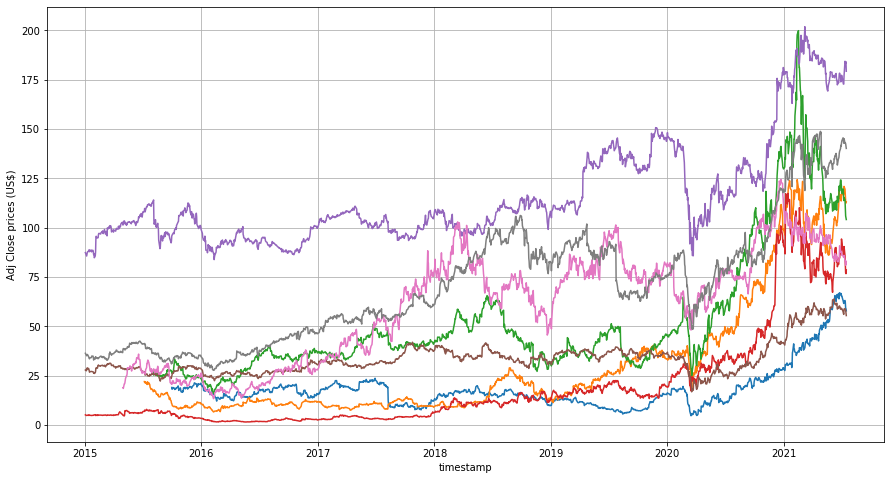

In [29]:
plt.figure(figsize= (15,8))
plt.plot(prices, label = 'Daily Closing price' )
# plt.xticks([])
plt.ylabel('Adj Close prices (US$)'); plt.xlabel('timestamp')
plt.grid(True); plt.show()

In [30]:
returns = prices.copy()
returns = returns.apply(lambda x: x.shift(-1)/x - 1, axis = 0)
returns # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,-0.058366,-0.014613,-0.014638,NaN,-0.027235
2015-01-05,NaN,NaN,NaN,0.002066,-0.005304,0.015147,NaN,-0.007919
2015-01-06,NaN,NaN,NaN,0.012371,0.010230,0.028407,NaN,0.003991
2015-01-07,NaN,NaN,NaN,-0.006110,0.010341,0.010045,NaN,0.015048
2015-01-08,NaN,NaN,NaN,0.022541,0.004904,-0.016851,NaN,-0.003636
...,...,...,...,...,...,...,...,...
2021-07-12,-0.016799,-0.025186,-0.033993,-0.052491,-0.003959,-0.004070,-0.011717,0.001260
2021-07-13,-0.044487,-0.026009,-0.039089,-0.052205,-0.001252,-0.012430,-0.020324,-0.003425
2021-07-14,-0.005904,-0.008813,-0.010193,-0.005962,0.003980,-0.018103,0.003705,-0.009048


## Momentun signal computation:

In [31]:
momentum_signal = prices.copy()

"""
return of the securities of last 6 weeks prior to the week we will be trading
we are not using current weeks because:
1. traditional momentum has atendency of short term reversal and longer term trend
2. it algns with execution strategy interms of  consistent with actual execution because
if we receive a signal on close price, we won't be able to execute immedeate
"""
momentum_signal = (momentum_signal.apply(func = lambda x: x.shift(1)/x.shift(7) - 1, axis = 0))
momentum_signal # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-12,-0.060943,0.065269,-0.056701,0.042171,0.007225,-0.006929,-0.022624,0.027467
2021-07-13,-0.032209,0.029726,-0.053565,-0.088769,0.040167,-0.002368,-0.045859,-0.000629
2021-07-14,-0.050360,-0.003081,-0.060177,-0.122737,0.036926,-0.003901,-0.039172,-0.006390


In [32]:
rank_df = momentum_signal.rank(axis =1)
rank_df # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-12,1.0,8.0,2.0,7.0,5.0,4.0,3.0,6.0
2021-07-13,4.0,7.0,2.0,1.0,8.0,5.0,3.0,6.0
2021-07-14,3.0,7.0,2.0,1.0,8.0,6.0,4.0,5.0


### creating signal >= 7 means 1, <=2 means -1, else 0

In [33]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

rank_df.tail() # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-07-12,-1,1,-1,1,0,0,0,0
2021-07-13,0,1,-1,-1,1,0,0,0
2021-07-14,0,1,-1,-1,1,0,0,0
2021-07-15,0,0,-1,-1,1,1,0,0
2021-07-16,0,0,-1,-1,1,1,0,0


In [34]:
portfolio = np.multiply(rank_df, returns)
portfolio.tail(50) # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-05-06,-0.006736,0.000000,-0.042154,0.000784,0.016778,0.000000,0.000000,0.000000
2021-05-07,-0.022670,-0.000000,0.051246,0.010197,-0.000000,-0.026784,-0.000000,-0.000000
2021-05-10,0.025377,-0.000000,-0.020539,-0.030247,-0.000000,-0.029263,0.000000,0.000000
2021-05-11,-0.052011,0.034238,0.052797,-0.000000,-0.000000,-0.035349,-0.000000,-0.000000
2021-05-12,0.038548,-0.020193,0.014901,-0.000000,0.000000,0.000000,0.000000,0.000718
2021-05-13,0.023763,-0.048021,-0.044631,0.000000,-0.000000,0.000000,0.039332,0.000000
2021-05-14,0.014579,0.014809,-0.000000,0.004694,-0.000000,0.000000,-0.026646,-0.000000
2021-05-17,-0.015315,-0.000000,-0.000000,0.000000,0.002352,0.002677,-0.003622,0.000000
2021-05-18,-0.005184,0.038142,-0.000000,-0.034730,0.002416,-0.000000,-0.000000,-0.000000


In [35]:
portfolio_returns = portfolio.sum(axis=1) / 3
portfolio_returns

Date
2015-01-02    0.000000
2015-01-05    0.000000
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.000000
                ...   
2021-07-12   -0.008962
2021-07-13    0.021344
2021-07-14    0.003774
2021-07-15   -0.023190
2021-07-16    0.000000
Length: 1646, dtype: float64

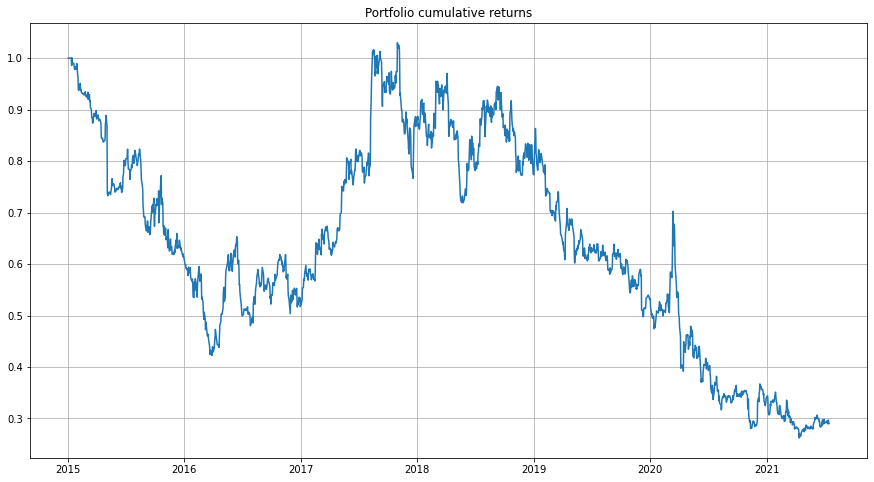

In [36]:
cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())

plt.figure(figsize= (15,8))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()